# <center>ADS 502: Introduction to Data Mining </center> - I hate the spacing and look of this and need to adjust...unless someone else can do it faster, haha!
# <center>Final Project, Spring 2025 </center>


## <center>Team One</center>

### Team One is
    * Mark Villanueva
    * Paul Matta
    * Katie Kimberling

## Data and Dataset Overview

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import Image 
import plotly.graph_objects as go
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings('ignore')

### Import the training Tanzania water csv files and obtain overview of all of the attributes and datatypes

In [2]:
pump_train_labels = pd.read_csv("https://raw.githubusercontent.com/KatieKimberling/ads-502-team-project/refs/heads/main/Pump_Train_Labels.csv")
print("The pump train LABELS dataset contains:") 
print(pump_train_labels.describe())
pump_train_labels.info()

pump_train_values = pd.read_csv("https://raw.githubusercontent.com/KatieKimberling/ads-502-team-project/refs/heads/main/Pump_Train_Values.csv")
print("The pump train VALUES dataset contains:") 
print(pump_train_values.describe())
pump_train_values.info()

The pump train LABELS dataset contains:
                 id
count  59400.000000
mean   37115.131768
std    21453.128371
min        0.000000
25%    18519.750000
50%    37061.500000
75%    55656.500000
max    74247.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.3+ KB
The pump train VALUES dataset contains:
                 id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519

### Merge the pump_train_values dataframe with the pump_train_labels dataframe to make one supervised training dataframe

In [3]:
ptrain = pd.merge(pump_train_values, pump_train_labels, on='id', how='inner')
ptrain.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Adjust date_recorded column to separate year from month from date

In [4]:
ptrain['date_recorded'] = pd.to_datetime(ptrain['date_recorded'])
ptrain['year_recorded'] = ptrain['date_recorded'].dt.year
ptrain['month_recorded'] = ptrain['date_recorded'].dt.month

ptrain = ptrain.drop(['date_recorded'], axis=1)
ptrain.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,2
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,1
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,7


In [5]:
ptrain['status_group'].value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

## Obtain, explore and handle missing values.

#### When prompted with "I want to show a list or grid or visual of how many missing values there are by variable" the ChatGPT-generated text indicated some of the following code to help me write a function to do so (OpenAI, 2025).

                   Missing Values  Percentage (%)
scheme_name                 28810       48.501684
scheme_management            3878        6.528620
installer                    3655        6.153199
funder                       3637        6.122896
public_meeting               3334        5.612795
permit                       3056        5.144781
subvillage                    371        0.624579
wpt_name                        2        0.003367


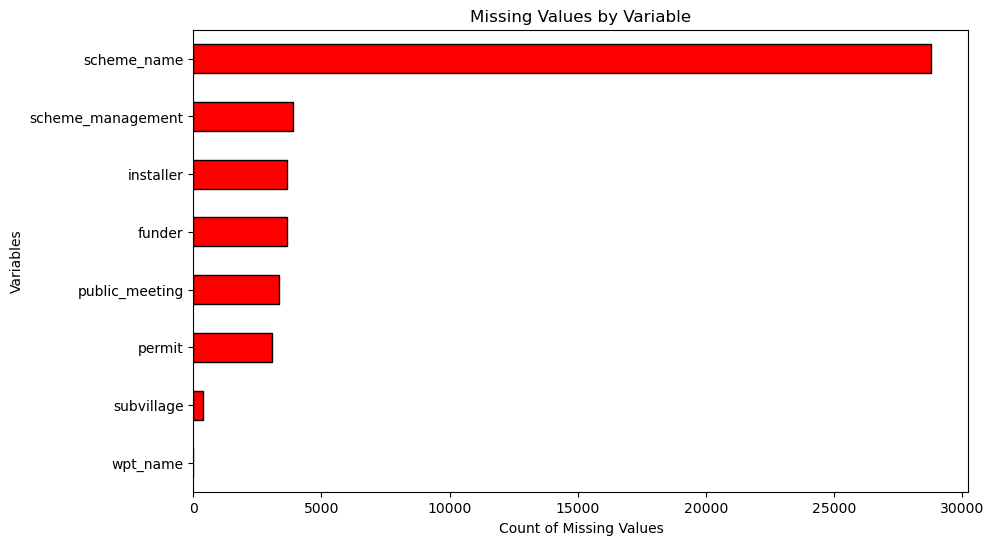

In [6]:
# Create function to identify missing values in all variables in dataframe

def missing_value_summary(ptrain):
        
    # Calculate missing values and percentages
    
    missing_values = ptrain.isnull().sum()
    missing_percent = (missing_values / len(ptrain)) * 100
    
    # Create a summary DataFrame
    
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_percent
    }).sort_values(by='Missing Values', ascending=False)
    
    # Filter out variables without any missing values (i.e. only keep in those variables WITH missing values)
    
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]
    
    # Display the summary
    
    print(missing_summary)

    # Plot missing values as a bar chart
    
    if not missing_summary.empty:
        plt.figure(figsize=(10, 6))
        missing_summary['Missing Values'].plot(kind='barh', color='red', edgecolor='black')
        plt.xlabel("Count of Missing Values")
        plt.ylabel("Variables")
        plt.title("Missing Values by Variable")
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.show()
    else:
        print("No missing values in the dataset!")

    return missing_summary  # Return the summary DataFrame

missing_summary = missing_value_summary(ptrain) 

## Replace missing values for permit and public_meeting with "unknown"

In [7]:
ptrain['permit'] = ptrain['permit'].fillna('unknown')
ptrain['public_meeting'] = ptrain['public_meeting'].fillna('unknown')

ptrain['permit'].value_counts()

permit
True       38852
False      17492
unknown     3056
Name: count, dtype: int64

## Obtain discrete different levels of nominal variables with their counts

In [8]:
def categorical_unique_counts(ptrain, categorical_vars):
     
    unique_counts = {col: ptrain[col].nunique() for col in categorical_vars}
    unique_counts_ptrain = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['Unique Count'])
    
    return unique_counts_ptrain

categorical_vars = ["scheme_name", "scheme_management", "installer", "funder", "public_meeting", "permit", "subvillage", "wpt_name", "status_group"]
unique_counts_summary = categorical_unique_counts(ptrain, categorical_vars)

# Display the summary
print(unique_counts_summary)

                   Unique Count
scheme_name                2695
scheme_management            11
installer                  2145
funder                     1896
public_meeting                3
permit                        3
subvillage                19287
wpt_name                  37399
status_group                  3


In [9]:
# Get the top 10 funders
top_funders = ptrain['funder'].value_counts().head(10)
print("Top 10 Funders:\n", top_funders)

# Get the top 10 installers
top_installers = ptrain['installer'].value_counts().head(10)
print("\nTop 10 Installers:\n", top_installers)

# Get the top 10 subvillages
top_subvillage = ptrain['subvillage'].value_counts().head(10)
print("\nTop 10 Subvillages:\n", top_subvillage)

# Get the top 10 scheme_names
top_scheme_names = ptrain['scheme_name'].value_counts().head(10)
print("\nTop 10 Scheme Names:\n", top_scheme_names)

Top 10 Funders:
 funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Name: count, dtype: int64

Top 10 Installers:
 installer
DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
Name: count, dtype: int64

Top 10 Subvillages:
 subvillage
Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
Sokoni      232
M           187
Muungano    172
Mbuyuni     164
Mlimani     152
Name: count, dtype: int64

Top 10 Scheme Names:
 scheme_name
K                              682
Borehole      

## Replace missing values for funder and installer with "other"

In [10]:
ptrain['funder'] = ptrain['funder'].fillna('other')
ptrain['installer'] = ptrain['installer'].fillna('other')

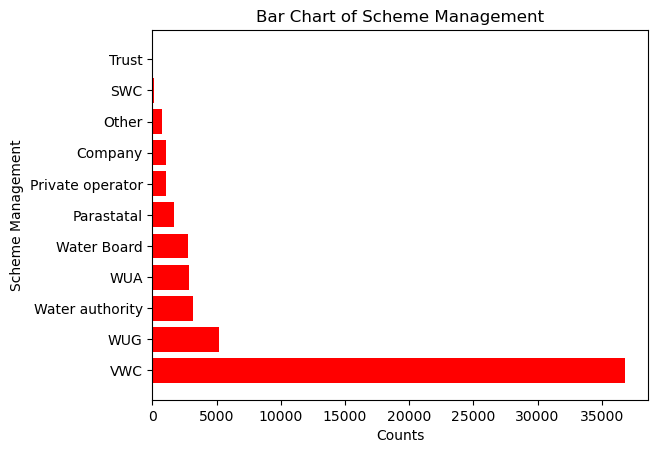

In [11]:
# Count the occurrences of each category in the scheme_management  column
scheme_mgt_counts = ptrain['scheme_management'].value_counts()

# Create a horizontal bar chart of scheme_management with the bars colored red
plt.barh(scheme_mgt_counts.index, scheme_mgt_counts.values, color=['red'])

# Add labels and title
plt.ylabel('Scheme Management')
plt.xlabel('Counts')
plt.title('Bar Chart of Scheme Management')

# Show the plot
plt.show()

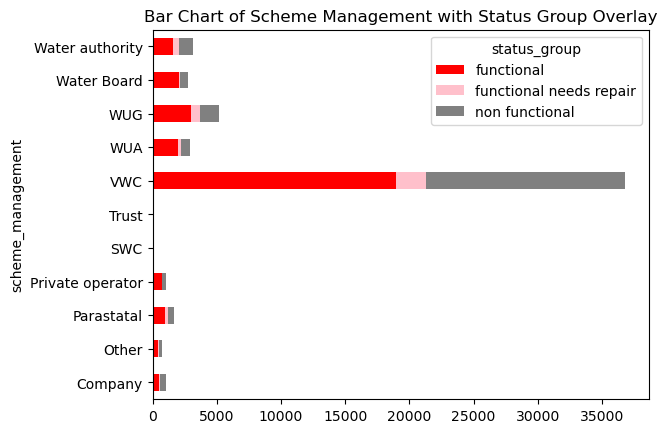

In [12]:
# See if scheme management has different status_group counts
crosstab_01=pd.crosstab(ptrain['scheme_management'], ptrain['status_group'])
crosstab_01.plot(kind='barh', stacked = True, color=['red', 'pink', 'gray'])
plt.title('Bar Chart of Scheme Management with Status Group Overlay')
plt.show()

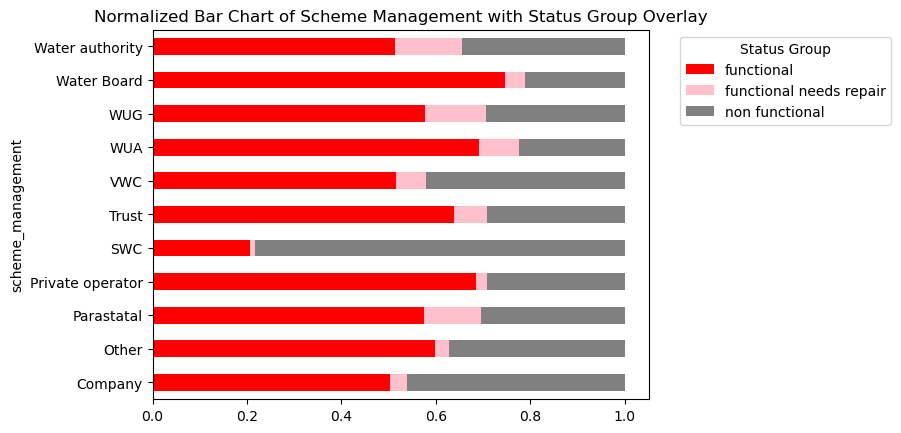

In [13]:
# Normalized bar graph of "scheme_management" with "status_group" overlay - best practices is to always show the non-normalized bar plot with the normalized one, and the former is shown above.
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis=0)
crosstab_norm.plot(kind='barh', stacked = True, color=['red', 'pink', 'gray'])
plt.title('Normalized Bar Chart of Scheme Management with Status Group Overlay')
plt.legend(title="Status Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [14]:
# Deleting records with missing values for scheme_management
ptrain.dropna(subset=["scheme_management"], inplace=True)
ptrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55522 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     55522 non-null  int64  
 1   amount_tsh             55522 non-null  float64
 2   funder                 55522 non-null  object 
 3   gps_height             55522 non-null  int64  
 4   installer              55522 non-null  object 
 5   longitude              55522 non-null  float64
 6   latitude               55522 non-null  float64
 7   wpt_name               55520 non-null  object 
 8   num_private            55522 non-null  int64  
 9   basin                  55522 non-null  object 
 10  subvillage             55159 non-null  object 
 11  region                 55522 non-null  object 
 12  region_code            55522 non-null  int64  
 13  district_code          55522 non-null  int64  
 14  lga                    55522 non-null  object 
 15  ward   

## Examine categorical variables without missing values

In [15]:
def cat_unique_counts(ptrain, cat_vars):
     
    unique_counts = {col: ptrain[col].nunique() for col in cat_vars}
    unique_counts_ptrain = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['Unique Count'])
    
    return unique_counts_ptrain

cat_vars = ["basin", "region", "lga", "ward", "extraction_type", "extraction_type_group", "extraction_type_class", "management", "management_group", "payment", "payment_type", "water_quality", "quality_group", "quantity", "quantity_group", "source", "source_type", "source_class", "waterpoint_type", "waterpoint_type_group"]
unique_counts_summary = cat_unique_counts(ptrain, cat_vars)

# Display the summary
print(unique_counts_summary)

                       Unique Count
basin                             9
region                           21
lga                             124
ward                           2017
extraction_type                  18
extraction_type_group            13
extraction_type_class             7
management                       12
management_group                  5
payment                           7
payment_type                      7
water_quality                     8
quality_group                     6
quantity                          5
quantity_group                    5
source                           10
source_type                       7
source_class                      3
waterpoint_type                   7
waterpoint_type_group             6


In [16]:
def value_counts_cat_col(ptrain):

    for col in ptrain.select_dtypes(include='object').columns:
        print(f"Value counts for column '{col}':")
        print(ptrain[col].value_counts())
        print("-" * 20) # Separator for better readability

value_counts_cat_col(ptrain)

Value counts for column 'funder':
funder
Government Of Tanzania    8552
other                     3591
Danida                    3108
Hesawa                    1722
Kkkt                      1268
                          ... 
Msigwa                       1
Mitema                       1
Siter Fransis                1
B.A.P                        1
Brown                        1
Name: count, Length: 1751, dtype: int64
--------------------
Value counts for column 'installer':
installer
DWE                15249
other               3596
Government          1807
Commu               1060
DANIDA              1046
                   ...  
MSIGWA                 1
Singida yetu           1
Anglican Uganda        1
Centra govt            1
SELEPTA                1
Name: count, Length: 2004, dtype: int64
--------------------
Value counts for column 'wpt_name':
wpt_name
none                 3411
Shuleni              1592
Zahanati              791
Msikitini             495
Kanisani              304

In [17]:
# View basin
basin = ptrain['basin'].value_counts().head(9)
print("Basin:\n", basin)

# View regions
region = ptrain['region'].value_counts().head(21)
print("\nRegions:\n", region)

# Get the top 10 lga
top_lga = ptrain['lga'].value_counts().head(10)
print("\nTop 10 lga:\n", top_lga)

# Get the top 10 wards
top_ward = ptrain['ward'].value_counts().head(10)
print("\nTop 10 Wards:\n", top_ward)

Basin:
 basin
Lake Victoria              8986
Pangani                    8819
Internal                   7621
Rufiji                     6814
Wami / Ruvu                5966
Lake Tanganyika            5862
Lake Nyasa                 5061
Ruvuma / Southern Coast    3955
Lake Rukwa                 2438
Name: count, dtype: int64

Regions:
 region
Iringa           5235
Mbeya            4635
Kilimanjaro      4357
Shinyanga        4207
Arusha           3290
Morogoro         2971
Kagera           2955
Kigoma           2795
Mwanza           2663
Pwani            2632
Ruvuma           2621
Tanga            2546
Dodoma           2196
Singida          2019
Tabora           1934
Rukwa            1787
Mara             1725
Mtwara           1546
Manyara          1490
Lindi            1120
Dar es Salaam     798
Name: count, dtype: int64

Top 10 lga:
 lga
Njombe          2461
Moshi Rural     1246
Arusha Rural    1225
Bariadi         1165
Rungwe          1106
Kilosa          1074
Kasulu          1044
M

### Obtain summary statistics of all numeric variables in ptrain dataframe and plot their histograms

id:
	 Mean = 37147.00
	 Median = 37095.50
	 Standard deviation = 21450.17
	 Minimum = 0.00
	 Maximum = 74247.00
	 Missing value count = 0.00
amount_tsh:
	 Mean = 333.54
	 Median = 0.00
	 Standard deviation = 3097.77
	 Minimum = 0.00
	 Maximum = 350000.00
	 Missing value count = 0.00
gps_height:
	 Mean = 688.54
	 Median = 436.50
	 Standard deviation = 698.67
	 Minimum = -90.00
	 Maximum = 2770.00
	 Missing value count = 0.00
longitude:
	 Mean = 34.09
	 Median = 34.91
	 Standard deviation = 6.55
	 Minimum = 0.00
	 Maximum = 40.32
	 Missing value count = 0.00
latitude:
	 Mean = -5.72
	 Median = -5.04
	 Standard deviation = 2.92
	 Minimum = -11.65
	 Maximum = -0.00
	 Missing value count = 0.00
num_private:
	 Mean = 0.49
	 Median = 0.00
	 Standard deviation = 12.45
	 Minimum = 0.00
	 Maximum = 1776.00
	 Missing value count = 0.00
region_code:
	 Mean = 14.72
	 Median = 12.00
	 Standard deviation = 16.69
	 Minimum = 1.00
	 Maximum = 99.00
	 Missing value count = 0.00
district_code:
	 Mean = 5

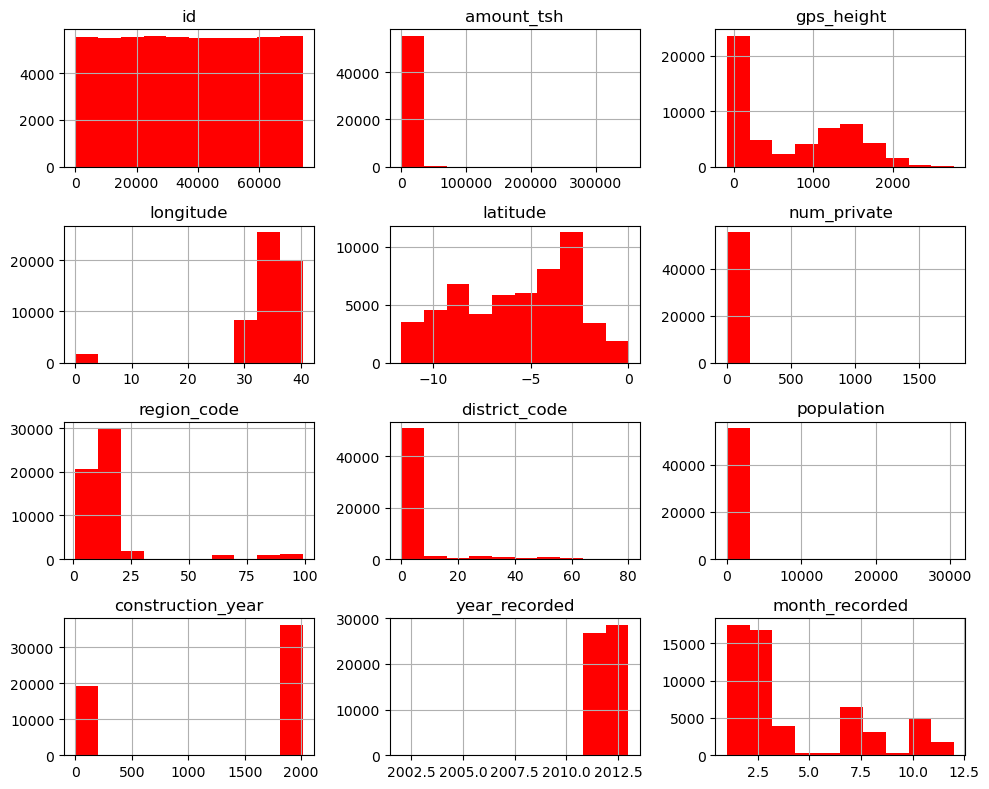

In [18]:
for col in ptrain.columns:
    if is_numeric_dtype(ptrain[col]):
        print('%s:' % (col))
        print('\t Mean = %.2f' % ptrain[col].mean())
        print('\t Median = %.2f' % ptrain[col].median())
        print('\t Standard deviation = %.2f' % ptrain[col].std())
        print('\t Minimum = %.2f' % ptrain[col].min())
        print('\t Maximum = %.2f' % ptrain[col].max())
        print('\t Missing value count = %.2f' % ptrain[col].isnull().sum())

def plot_numerical_histograms(ptrain):
    numerical_cols = ptrain.select_dtypes(include=['number']).columns
    ptrain[numerical_cols].hist(figsize = (10,8), color="red")
    plt.tight_layout()
    plt.show()
plot_numerical_histograms(ptrain)

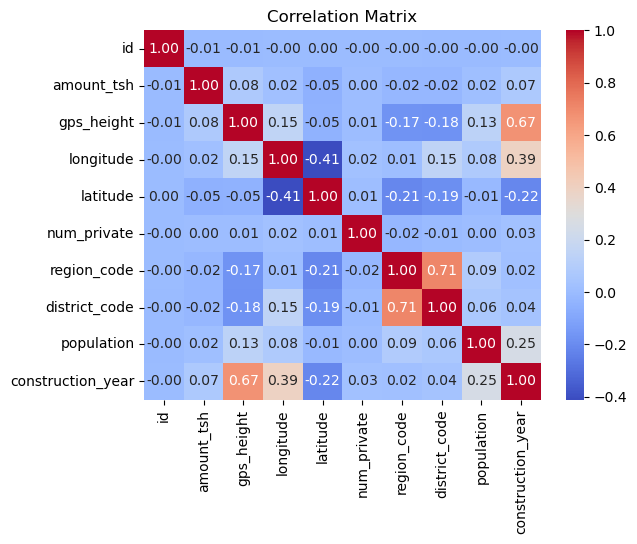

In [19]:
# Calculate the correlation matrix

# Select only numeric columns
numeric_df = ptrain.select_dtypes(include=["int64", "float64"])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Raw Box and Whisker Plots of Population by Region (Waskom, 2024)

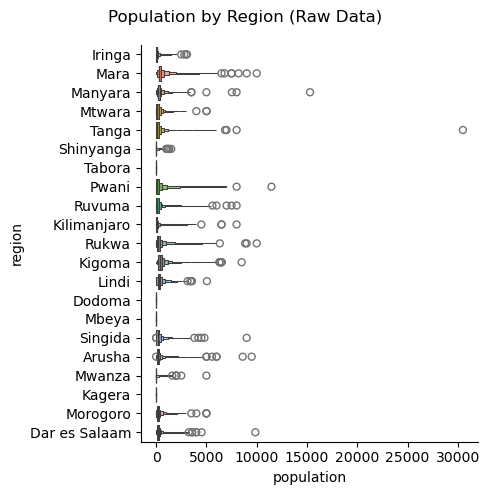

In [20]:
g = sns.catplot(data=ptrain, x="population", y="region", palette="husl", kind="boxen")
g.fig.suptitle("Population by Region (Raw Data)")
plt.tight_layout()

#### There are significant outliers on the upper end in each region, which is skewing the data. Outliers were identified as being beyond 1.5*IQR and removed from the variable population by region as shown below.

### Detect and recode outliers using IQR method (Geeks for Geeks, 2025)

In [21]:
# Function to identify and remove outliers using IQR

def remove_outliers_iqr(ptrain, columns):
    for col in columns:
        Q1 = ptrain[col].quantile(0.25)
        Q3 = ptrain[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Keep only values within the bounds
        ptrain = ptrain[(ptrain[col] >= lower_bound) & (ptrain[col] <= upper_bound)]
    
    return ptrain
    
# List of numerical variables to check for outliers: population, amount_tsh and gps_height
clean_columns = ["population", "amount_tsh", "gps_height"]
ptrain_cleaned = remove_outliers_iqr(ptrain, clean_columns)

# Apply outlier removal to each region
print(ptrain_cleaned.describe())

                 id    amount_tsh    gps_height     longitude      latitude  \
count  42062.000000  42062.000000  42062.000000  42062.000000  4.206200e+04   
mean   37197.157458      4.050988    555.017332     33.735292 -5.344074e+00   
std    21484.883999     11.967082    674.043157      7.330503  2.921677e+00   
min        0.000000      0.000000    -63.000000      0.000000 -1.158630e+01   
25%    18596.250000      0.000000      0.000000     33.047365 -7.833068e+00   
50%    37169.500000      0.000000     71.000000     34.752735 -4.663181e+00   
75%    55782.250000      0.000000   1243.000000     37.212828 -3.237978e+00   
max    74246.000000     50.000000   2770.000000     40.298026 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  42062.000000  42062.000000   42062.000000  42062.000000   
mean       0.531263     15.001878       5.949765     80.605796   
std       13.526364     17.107621       9.829413    128.352097   
min        0.000000     

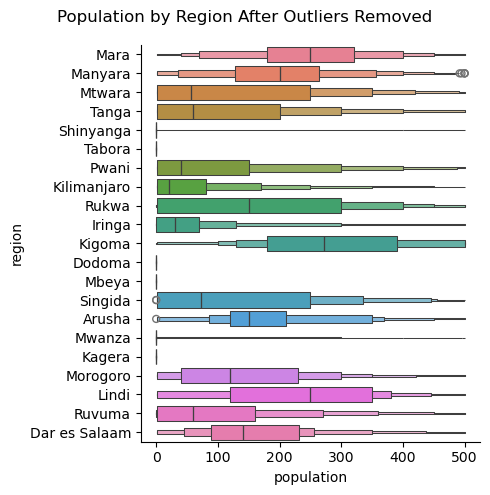

In [22]:
g = sns.catplot(data=ptrain_cleaned, x="population", y="region", palette="husl", kind="boxen")
g.fig.suptitle("Population by Region After Outliers Removed")
plt.tight_layout()

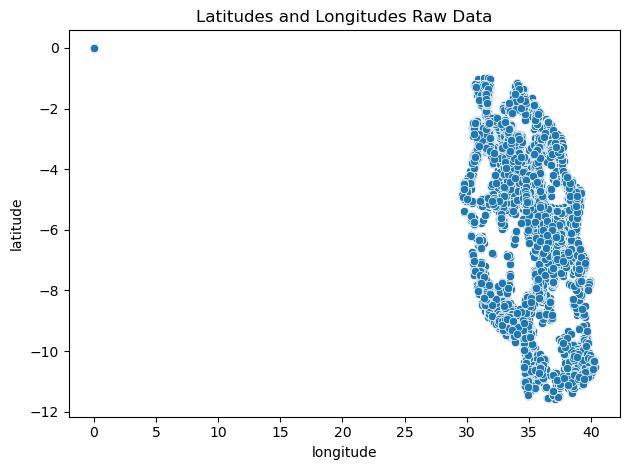

In [23]:
sns.scatterplot(data=ptrain_cleaned, x="longitude", y="latitude")
plt.title("Latitudes and Longitudes Raw Data")
plt.tight_layout()

## Adjust latitudes and longitudes to fit Tanzania

Text(0.5, 1.0, 'Adjusted Latitudes and Longitudes')

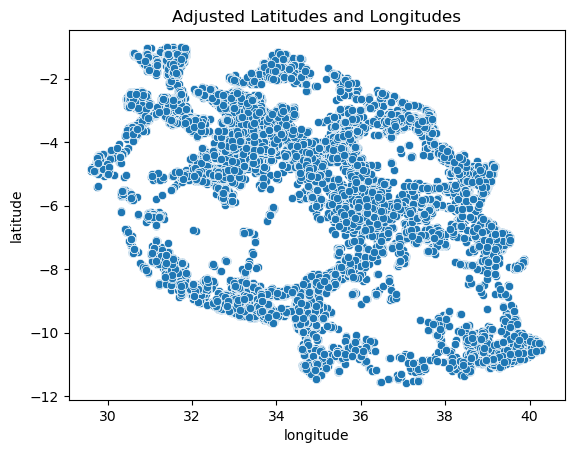

In [24]:
# Define valid ranges
valid_lat_range = (-15, 5)
valid_lon_range = (25, 42)

# Filter outliers
ptrain_cleaned = ptrain_cleaned[ptrain_cleaned['latitude'].between(*valid_lat_range) & ptrain_cleaned['longitude'].between(*valid_lon_range)]
sns.scatterplot(data=ptrain_cleaned, x="longitude", y="latitude")
plt.title("Adjusted Latitudes and Longitudes")

## Drop all unnecessary variables/features/attributes/columns

In [25]:
ptrain_cleaned = ptrain_cleaned.drop(['scheme_name', 'subvillage', 'wpt_name', 'num_private', 'region', 'lga', 'ward', 'recorded_by', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'id'], axis=1)
ptrain_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40377 entries, 1 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40377 non-null  float64
 1   funder                 40377 non-null  object 
 2   gps_height             40377 non-null  int64  
 3   installer              40377 non-null  object 
 4   longitude              40377 non-null  float64
 5   latitude               40377 non-null  float64
 6   basin                  40377 non-null  object 
 7   region_code            40377 non-null  int64  
 8   district_code          40377 non-null  int64  
 9   population             40377 non-null  int64  
 10  public_meeting         40377 non-null  object 
 11  scheme_management      40377 non-null  object 
 12  permit                 40377 non-null  object 
 13  construction_year      40377 non-null  int64  
 14  extraction_type_group  40377 non-null  object 
 15  payment

### References

Geeks for Geeks. (2025, Jan 2). Detect and remove the outliers using Python. Geeks for Geeks. https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

Kahn, R. (2020). Pump it up: Data mining the water table [Map]. GitHub. [https://github.com/rkhan15/taarifa-pump] 

OpenAI. (2025). ChatGPT (Mar 26 version) [Large language model]. https://chat.openai.com/chat

Waskom, M. (2024). Visualizing categorical data. Seaborn. https://seaborn.pydata.org/tutorial/categorical.html